In [1]:
# Run this cell is your are developing the code locally
%load_ext autoreload
%autoreload 2
import sys
import site
site.addsitedir('../') 

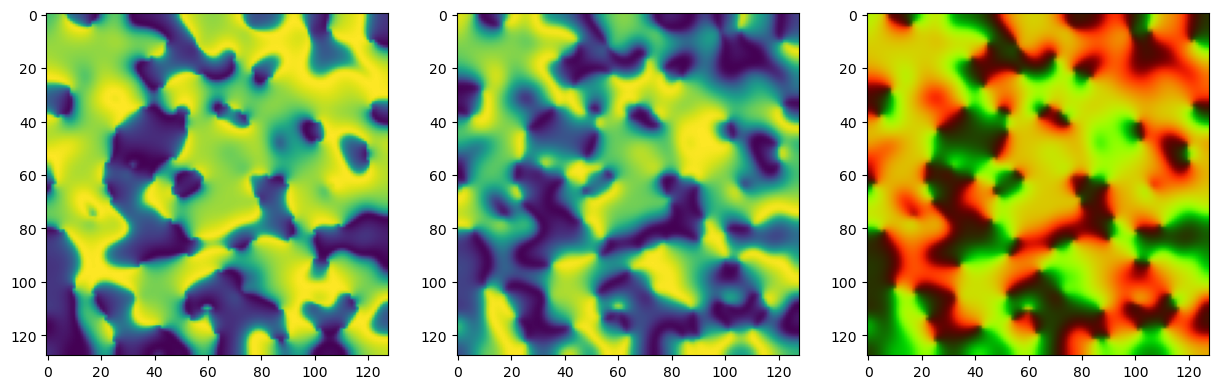

In [385]:
from mug import data, utils
import numpy as np
from numpy.random import default_rng
from scipy.ndimage import median_filter, laplace
import matplotlib.pyplot as plt

from skimage import measure
rng = default_rng()

shape = [128,128]
#FitzHugh–Nagumo model
field = rng.standard_normal([2, *shape])
dt = 0.01
tau = 3
du = 1
dv = 10
s = 100
l = 10
k = 1
for _ in range(500):
    u = du * laplace(field[0]) + l * field[0] - field[0]**3 - k - s * field[1]
    v = (dv * laplace(field[1]) + field[0] - field[1])/tau
    field = field + dt * np.stack([u,v])
field[0] = (field[0] - field[0].min()) / (field[0].max()-field[0].min())
field[1] = (field[1] - field[1].min()) / (field[1].max()-field[1].min())

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(field[0])
ax[1].imshow(field[1])
ax[2].imshow(np.stack([field[0], field[1], np.zeros(shape)],axis=2))
 

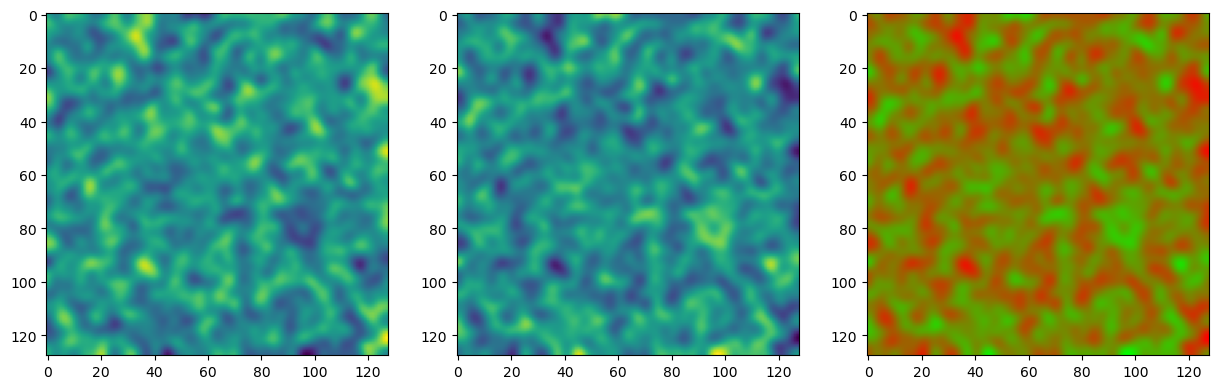

In [526]:
def simple_pattern(shape,niter,dt,a,b,q,r,D):
    from numpy.random import default_rng
    rng = default_rng()    
    field = rng.standard_normal([2, *shape], dtype=np.float32)
    from scipy.ndimage import gaussian_filter, laplace
    field = np.stack([gaussian_filter(f,2,mode='reflect') for f in field])
    field = (field - field.min()) / (field.max()-field.min())
    for _ in range(niter):        
        u,v = field
        update =  np.stack([
            D * laplace(u) + a * u + q * v,
            laplace(v)     + b * v + r * u
        ])
        update = dt * update / ( 1 + max(abs(update.min()), abs(update.max())))
        field = field + update
    return field
field = simple_pattern([128,128], niter=5000, dt=0.21, a=0.5, b=0.5, q=-10, r=-10, D=0.5)
field[0] = (field[0] - field[0].min()) / (field[0].max()-field[0].min())
field[1] = (field[1] - field[1].min()) / (field[1].max()-field[1].min())
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(field[0])
ax[1].imshow(field[1])
ax[2].imshow(np.stack([field[0], field[1], np.zeros((128,128))],axis=2))

In [1386]:
from numba import jit
from numba import stencil
@stencil
def laplace3(u):
    return -6 * u[0,0,0] + u[-1,0,0] + u[1,0,0] + u[0,-1,0] + u[0,1,0] + u[0,0,-1] + u[0,0,1]

@stencil
def laplace2(u):
    return -4 * u[0,0] + u[-1,0] + u[1,0] + u[0,-1] + u[0,1]



@jit(nopython=True,parallel=True)
def mylaplace(u):    
    if len(u.shape) == 3:        
        return laplace3(u)
    else:
        return laplace2(u)

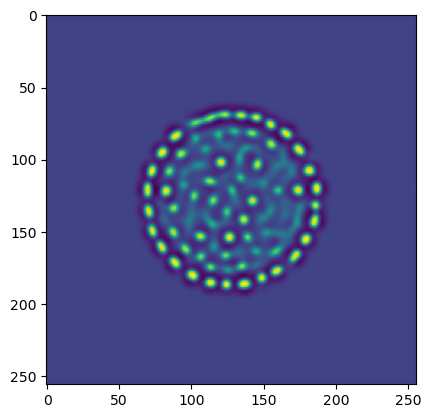

In [63]:
import numpy as np
def turing_pattern(mask,niter,dt,a,b,q,r,D):
    """ Generate a Turing pattern usign a reaction diffusion simulation

    du/dt = a u (1 - q v^2) + v (1 - ru)
    dv/dt = v ( b + a q u v) + u (-a + rv)
    http://www.dna.caltech.edu/courses/cs191/paperscs191/turing.pdf
    """
    from numpy.random import default_rng
    rng = default_rng()
    field = rng.standard_normal([2, *mask.shape], dtype=np.float32)    
    from scipy.ndimage import gaussian_filter, laplace
    field = np.stack([gaussian_filter(f,1,mode='reflect') for f in field])
    field = (field - field.min()) / (field.max()-field.min())
    mask = gaussian_filter(mask.astype(float), 2)  
    #field = field * mask
    for _ in range(niter):        
        u, v = field
        update =  np.stack([
            D * laplace(u) + a * u * (1 - q * v * v) + v * (1. - r * u),
            laplace(v) + v * (b + a * q * u * v) + u * (-a + r * v)
        ])
        update = dt * update# / ( 1 + max(abs(update.min()), abs(update.max())))
        field = field + update
        field[0] = field[0] - dt*0.01*(1 - mask)        
        
    field[0] = (field[0] - field[0].min()) / (field[0].max()-field[0].min())
    field[1] = (field[1] - field[1].min()) / (field[1].max()-field[1].min())
    return field
    
shape = (256,256)
g = np.meshgrid(*[np.arange(-n//2, n//2) for n in shape])
R = np.sqrt(sum([gn**2 for gn in g]))
mask = (R < shape[0] / 4) #* (R > shape[0] / 8)
field = turing_pattern(mask, niter=1000, dt=0.1, a=0.855, b=-0.95, q=0.5, r=0.5, D=0.5)
plt.imshow(field[0])

## 2D example

In [5]:
from mug import utils, data
def tissue_2d(shape, scale):
    from scipy.ndimage import gaussian_filter, zoom
    from skimage.morphology import thin
    shape0 = [n//scale for n in scale]
    g = np.meshgrid(*[np.arange(-n//2, n//2) for n in shape0])
    R = np.sqrt(sum([gn**2 for gn in g]))
    mask = (R < (shape[0] / 2 - 2)) #* (R > shape[0] / 8)    
    field = data.turing_pattern(mask, niter=1000, dt=1, a=0.855, b=-0.95, q=0.5, r=0.5, D=0.5)
    field = zoom(field,[1,4,4])
    skel = thin((field[1]>0.5*field[1].mean())).astype(float)
    field2 = data.turing_pattern(field[0]>0.5, niter=500, dt=0.5, a=0.855, b=-0.95, q=1, r=0.5, D=0.1)
    
    

    
    

Elapsed time 0.1996 seconds.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


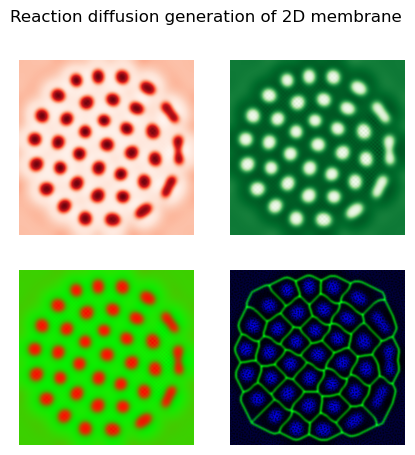

In [7]:
import matplotlib.pyplot as plt
from mug import utils, data
import numpy as np
from skimage.morphology import thin
from scipy.ndimage import gaussian_filter, zoom
import time
shape = (90,90)
g = np.meshgrid(*[np.arange(-n//2, n//2) for n in shape])
R = np.sqrt(sum([gn**2 for gn in g]))
mask = (R < (shape[0] / 2 - 4)) #* (R > shape[0] / 8)
start_time = time.time()
field = data.turing_pattern(mask, niter=1000, dt=1, a=0.855, b=-0.95, q=0.5, r=0.5, D=0.5)
end_time = time.time()
print(f'Elapsed time {end_time-start_time:.4g} seconds.')
field = zoom(field,[1,4,4])
field2 = data.turing_pattern(field[0]>0.0, niter=500, dt=0.5, a=0.85, b=-0.95, q=2, r=0.5, D=0.1)
skel = thin((field[1]>0.5*field[1].mean())).astype(float)
membrane = gaussian_filter(skel,2)
membrane = (membrane-membrane.min())/membrane.ptp()
nuclei = gaussian_filter(np.sqrt(field2[0])*field[0],0.1) 
fig, ax = plt.subplots(2,2,figsize=(5,5))
ax[0,0].imshow(field[0],cmap='Reds')
ax[0,1].imshow(field[1],cmap='Greens')
ax[1,0].imshow(np.stack([field[0], field[1], np.zeros_like(field[0])],axis=2))
ax[1,1].imshow(np.stack([np.zeros_like(field[0]),membrane,nuclei],axis=2))
for a in ax.flatten():
    a.axis('off')
plt.suptitle('Reaction diffusion generation of 2D membrane');

# 3D example

In [4]:
shape = (64,64,64)
g = np.meshgrid(*[np.arange(-n//2,n//2) for n in shape], indexing='ij')
mask = (np.sqrt(sum([gn**2 for gn in g])) < (shape[0]//2 - 8)).astype(float)
start_time = time.time()
field = turing_pattern(mask, niter=2000, dt=1, a=0.855, b=-0.91, q=0.5, r=0.5, D=0.5)
end_time = time.time()
print(f'Elapsed time {end_time-start_time:.4g} seconds.')
plt.imshow(utils.mip3d(field[0]))
   

NameError: name 'turing_pattern' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.98, 'Reaction diffusion generation of 3D membrane')

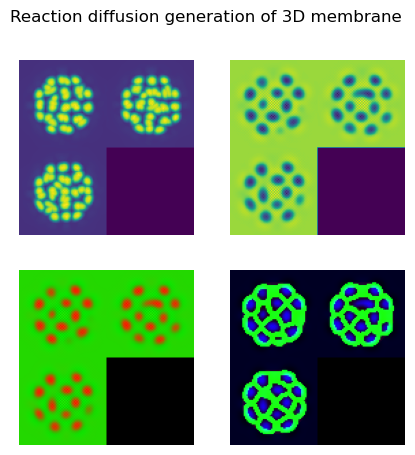

In [361]:
from skimage.morphology import skeletonize_3d
from scipy.ndimage import gaussian_filter
skel = skeletonize_3d(mask*(field[1]>0.5*field[1].mean())).astype(float)
skel = gaussian_filter(skel,0.5)
fig, ax = plt.subplots(2,2,figsize=(5,5))
ax[0,0].imshow(utils.mip3d(field[0]))
ax[0,1].imshow(utils.slice3d(field[1]))
ax[1,0].imshow(np.stack([utils.slice3d(x) for x in [field[0], field[1], np.zeros(shape)]], axis=2))
ax[1,1].imshow(np.stack([utils.slice3d(x) for x in [0.5*mask,skel,field[0]]], axis=2))
for a in ax.flatten():
    a.axis('off')
plt.suptitle('Reaction diffusion generation of 3D membrane')

In [362]:
import napari

napari.view_image(np.stack([field[0], skel]),channel_axis=0,rendering='attenuated_mip',ndisplay=3)



Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(31.5, 31.5, 31.5), zoom=20.52890625, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(32.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=3, last_used=0, range=((0.0, 64.0, 1.0), (0.0, 64.0, 1.0), (0.0, 64.0, 1.0)), current_step=(32, 32, 32), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'Image' at 0x7fce95dbe9a0>, <Image layer 'Image [1]' at 0x7fce95dd8fd0>], scale_bar=ScaleBar(visible=False, colored=False, color=array([1., 0., 1., 1.], dtype=float32), ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, box=False, box_color=array([0. , 0. , 0. , 0.6], dtype=float32), unit=None), text_overlay=TextOverlay(visible=False, color=array([0.5, 0.5, 0.5, 1. ], dtype=float32), font_size=10.0, 

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

shape = [32,64,64]
data = np.zeros(shape)

p = [[16,24,32],[16,12,32]]

X = np.meshgrid(*[np.arange(n) for n in shape], indexing='ij')
d = np.sqrt(sum([np.square(X[k]-p[k]) for k in range(3)]))

mask = d < 10

rng = np.random.default_rng()
for _ in range(50):
    mask = median_filter(mask + 0.25*rng.standard_normal(mask.shape), 3) > 0.5


plt.imshow(mask)

#from skimage import io
#f0 = io.imread('../data/earth.png')
# dfs
#f = np.concatenate([f0, np.flip(f0)])
#plt.imshow(f)
#


ValueError: operands could not be broadcast together with shapes (32,64,64) (3,) 

(512, 512)

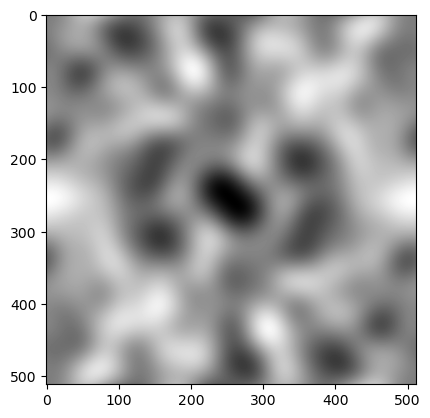

(512, 512)

In [132]:
#f0 = io.imread('../data/earth.png')[:,:,0]
f0 = np.random.normal(0,1,size=(256,512))
# create the double fourier sphere
f = np.concatenate([f0, np.flip(f0)])
# filter the sphere
F = np.fft.fftn(f)
G = np.exp(-10000*np.square(np.stack(np.meshgrid(*[np.fft.fftfreq(n) for n in F.shape]),axis=0)).sum(axis=0))
f = np.real(np.fft.ifftn(F * G))
f0 = f[:,0:f.shape[0]//2]
f0 = f
plt.imshow(f0,cmap='gray')
plt.show()
f0 = f0/ f0.ptp()
f0.shape

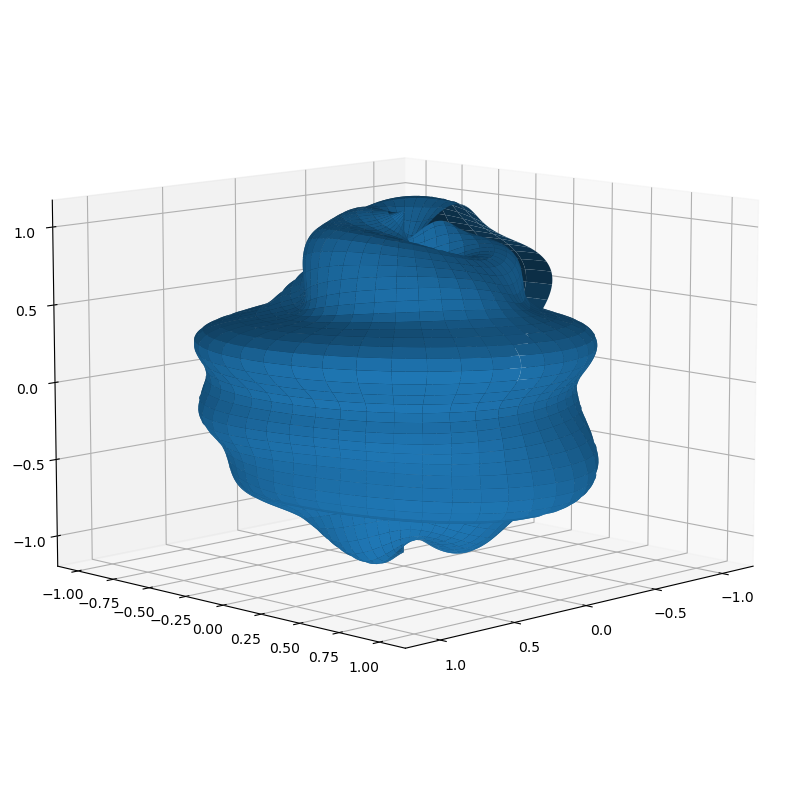

In [131]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
az,el = np.meshgrid(np.linspace(-math.pi,math.pi,f0.shape[1]),np.linspace(0,math.pi,f0.shape[0]))
R  = 1 + 0.5*f0
x = R*np.cos(az)*np.sin(el)
y = R*np.sin(az)*np.sin(el)
z = R*np.cos(el)
ax.plot_surface(x, y, z)
ax.view_init(elev=10, azim=45)
plt.show()



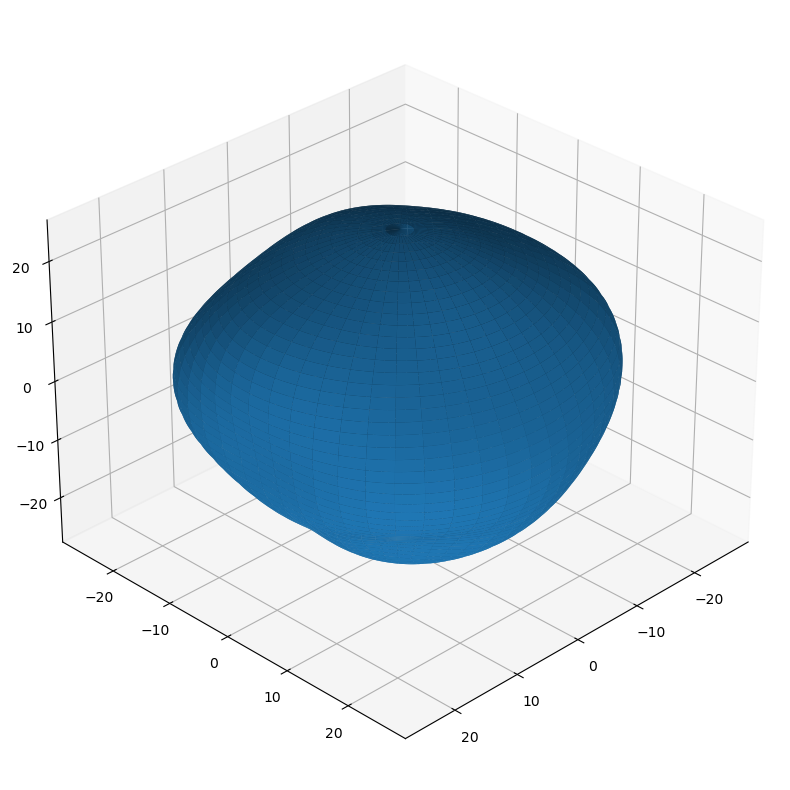

In [657]:
from scipy.special import sph_harm
az,el = np.meshgrid(
    np.linspace(-math.pi,math.pi,200),
    np.linspace(0,math.pi,200))
R = 25
rng = np.random.default_rng()
for n in range(1,7):
    for m in range(-n,n):
        R = R + 25*0.2/(n)*rng.standard_normal()*np.real(sph_harm(m,n,az,el))
x = R*np.cos(az)*np.sin(el)
y = R*np.sin(az)*np.sin(el)
z = R*np.cos(el)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z)
ax.view_init(elev=30, azim=45)
plt.show()


1418 35.810993401031425


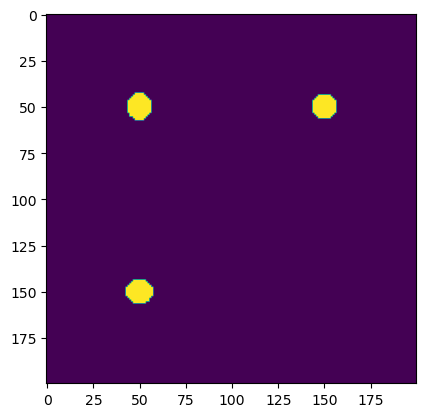

In [671]:
# create a mask based on a spherical harmonic
#
from scipy.special import sph_harm
# set pixel inide the domain to 1 
shape = [100,100,100]
center = [50,50,50]
radius = 20

def fill_spheric(shape, center, fun):
    """Fill the domain defined by a function defined in spherical coordinates"""
    zyx = np.meshgrid(*[np.arange(n) for n in shape])
    sxy = np.sqrt(sum([np.square(zyx[n] - center[n]) for n in range(1,3)]))
    r   = np.sqrt(sum([np.square(zyx[n] - center[n]) for n in range(3)]))
    az = np.arctan2(zyx[1], zyx[2])
    el = np.arctan2(sxy, zyx[0])
    return r < fun(az,el)

def make_sphfun(coef):
    # spherical function factory
    K = len(coef)
    N = int(math.sqrt(K)-1)    
    def myfun(az,el):
        val = 0
        k = 0
        for n in range(0,N+1):
            for m in range(-n,n+1):
                val = val + coef[k] * np.real(sph_harm(m,n,az,el))
                k = k +1
        return val
    return myfun

#create coefficients
def generate_sphcoef(R,N):
    rng = np.random.default_rng()
    coef = [R]
    for n in range(1,N+1):
        for m in range(-n,n+1):            
            coef.append(0.25 * R / (n*n) * rng.standard_normal() )
    return coef

coef = generate_sphcoef(50,7)
f = make_sphfun(coef)
Z = fill_spheric(shape, center, f)
print(Z.sum(),np.array(coef).sum())

from mug import utils
plt.imshow(utils.mip3d(Z))

In [ ]:
def generate(shape):
    
    # create a map
    f0 = np.random.normal(0,1,size=(256,512))
    # create the double fourier sphere by extending f0
    f = np.concatenate([f0, np.flip(f0)])
    # filter the double fourier sphere
    F = np.fft.fftn(f)
    G = np.exp(-1000*np.square(np.stack(np.meshgrid(*[np.fft.fftfreq(n) for n in F.shape]),axis=0)).sum(axis=0))
    f = np.real(np.fft.ifftn(F * G))
    # crop the dfs
    f0 = f[0:f.shape[0]//2,:]
    # 
    x,y,z = np.meshgrid(*[np.arange(n) for n in shape])
    
    # compute the coordinates of the points on the sphere
    az,el = np.meshgrid(
        np.linspace(-math.pi,math.pi,f0.shape[1]),
        np.linspace(0,math.pi,f0.shape[0]))
    R  = 1 + 2*f0
    x = R*np.cos(az)*np.sin(el)
    y = R*np.sin(az)*np.sin(el)
    z = R*np.cos(el)

In [ ]:
import numpy as np
import scipy

def generate_membranes(shape, pixel_size, n):
    """Generate membranes"""
    # generate random coordinates in 3D
    dim = len(shape)
    img = np.zeros([x+4 for x in shape])
    points = np.random.uniform(size=(n, dim))
    points = np.array(img.shape) * (0.05 + 0.95 * points)
    points = points.astype(np.int)
    # create an image with ones at the location of the points
    for p in points:
        img[tuple(p)] = 1
    img = scipy.ndimage.morphology.distance_transform_edt(1-img)
    img = (scipy.ndimage.laplace(img, mode='constant', cval=100) < 0.01)
    img = scipy.ndimage.gaussian_filter(img.astype(np.float32), 0.5)
    img = img[tuple(slice(2, n + 2, 1) for n in shape)]
    return img.astype(np.float32)